# KSP 6.0 Selection Assignment

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Section 1: Computational Astronomy

### Part A
In this part, we will try to characterise the orbit of an object orbiting another object in a circular orbit.


Suppose we are observing a star orbiting a black hole.
The black hole will not be visible, however the star will be visible through some kind of telescope.

In astronomy, we use an ["Equatorial Coordinate System"](https://en.wikipedia.org/wiki/Equatorial_coordinate_system) to write down the positions of celestial bodies. This consists of two coordinates, a longitude-like ["Right Ascension"](https://en.wikipedia.org/wiki/Right_ascension)("RA") and a latitude-like ["Declination"](https://en.wikipedia.org/wiki/Declination). However, celestial bodies are not fixed but move constantly. This is captured as a phenomenon called ["Proper Motion"](https://en.wikipedia.org/wiki/Proper_motion).

Additionally, the plane of orbit need not be perpendicular to our line of sight. This will lead to distortions in the orbit.

You are given observed RA (in hours )and Dec (in degrees) of the celestial body. We are also given that the celestial body is $R = 6.9 \times 10^{19}m$ away from us. You are also given the radial velocity of the object (in $m/s$) from us.

Firstly, write code to import the data from "simple.csv". For your convenience, write it to accept any filename. It should output data as a numpy array of shape N×4.

In [30]:
def load_data(filename):
    data = np.genfromtxt(filename, delimiter=',', skip_header=1)
    return data

To convert change in RA to angle measurements in that direction, we need to adjust it by a factor dependent on the mean position of the celestial body. Convert both the data into mas (milli arc seconds). The data is given with the respect to the origin point $53^\circ 47' 31''$ declination and $12h 14m 43s$ as the RA. Convert it to mas wrt the same point in the below cell


In [31]:
def convert_to_mas(data):
   
    ra_hours = data[:, 1]
    dec_deg = data[:, 2]
    time = data[:, 0]
    radial_velocity = data[:, 3]

    ra_deg = ra_hours * 15

    ra_mas = (ra_deg) * 3600 * 1000 * np.cos(np.deg2rad(dec_deg))
    dec_mas = (dec_deg) * 3600 * 1000

    return np.column_stack((ra_mas, dec_mas, time, radial_velocity))

Now, plot the loaded data using matplotlib the coordinates in milli arcseconds on the two axes.

In [32]:
def plot_full_data(data_mas):
    plt.subplot(1, 1, 1)
    plt.scatter(data_mas[:, 0], data_mas[:, 1])
    plt.title("Initial Data (mas)")
    plt.xlabel("ΔRA (mas)")
    plt.ylabel("ΔDec (mas)")

Next, we need to remove the proper motion of the black hole, which we see as moving in a straight line. Motion of the star is the resultant of the orbit and the proper motion of the black hole. Using the fact that the orbital motion is periodic, find the proper motion $(\mu_\alpha, \mu_\delta)$ and return it as a tuple.

In [33]:
def proper_motion(data):
    time = data[:, 2]/31536000 
    ra = data[:, 0]
    dec = data[:, 1]
    
    mu_alpha_cosdec, _ = np.polyfit(time, ra, 1)
    mu_delta, _ = np.polyfit(time, dec, 1)

    return mu_alpha_cosdec, mu_delta

Now, we can remove the effect of proper motion, which is simply a constant-velocity like motion. Modify the data to remove its effect and return data.

In [34]:
def remove_proper_motion(data, mu_ra, mu_dec):
    times = data[:,2]/31536000 #converting to years
    ra_corrected = data[:, 0] - mu_ra * times
    dec_corrected = data[:, 1] - mu_dec * times
    return np.column_stack((ra_corrected, dec_corrected, times, data[:, 3]))

Plot the data corrected for proper motion. The data should now form a closed loop.

In [35]:
def plot_corrected_orbit(corrected_data):
    plt.figure(figsize=(8, 8))
    plt.plot(corrected_data[:, 0], corrected_data[:, 1], 'o-', color='black', markersize=1)
    plt.title("After proper motion Correction")
    plt.xlabel("Delta RA (mas)")
    plt.ylabel("Delta Dec (mas)")
    plt.grid(True)
    plt.axis('equal')
    plt.show()
    

The orbit of the star is circular, but it may not orbit with the plane perpendicular to our line of sight. This discrepancy is called [inclination](https://en.wikipedia.org/wiki/Orbital_inclination), which leads to the orbit not visually looking circular. Find the inclination of the orbit, with or without using the radial velocity data.

In [36]:
def inclination(data):
    ra = data[:, 0]
    dec = data[:, 1]
    a = (np.max(ra) - np.min(ra)) / 2
    b = (np.max(dec) - np.min(dec)) / 2
    return np.degrees(np.arccos(min(a, b) / max(a, b)))

To really understand the orbit, we should view it from "above" the plane of motion. To achieve that, we must therefore rotate the orbit about the "reference line" by the inclination. Through that, create an N×3 numpy array of timestamped planar motion.

In [37]:
def rotate_orbit(data, inclination_deg):

    x, y, t = data[:, 0], data[:, 1], data[:, 2]
    
    y_corrected = y / np.cos(np.radians(inclination_deg))

    x_centered = x - np.mean(x)
    y_centered = y_corrected - np.mean(y_corrected)
    
    covariance_matrix = np.cov(x_centered, y_centered)
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    rotation_matrix = eigenvectors.T  
    
    rotated_x, rotated_y = rotation_matrix @ [x_centered, y_centered]
    
    return np.column_stack((rotated_x, rotated_y, t))

Plot this corrected data using matplotlib.

In [38]:
def plot_rotated_orbit(rotated_data):
    plt.figure(figsize=(8, 8))
    plt.plot(rotated_data[:, 0], rotated_data[:, 1], 'o-', color='black', markersize=1)
    plt.title("Orbit After Inclination Correction")
    plt.xlabel("Delta RA (mas)")
    plt.ylabel("Delta Dec (mas)")
    plt.grid(True)
    plt.axis('equal')
    plt.show()

Now, we can calculate the radius $r$ of the orbit. Return $r$

In [39]:
def radius(data):
    return (np.sqrt(data[:, 0]**2 + data[:, 1]**2)).mean()

Find the time period of the orbit using the final rotated orbital data.

In [40]:
def time_period(data):
    times = data[:, 2]      
    rv = data[:, 3]          

    zero_crossings = []
    for i in range(1, len(rv)):
        if rv[i-1] < 0 and rv[i] >= 0:
            t0 = times[i-1]
            t1 = times[i]
            crossing_time = t0 
            zero_crossings.append(crossing_time)

    intervals = np.diff(zero_crossings)
    avg_time_period = np.mean(intervals)

    return (avg_time_period)   

Using the radius of the orbit and the time period, find the mass $M$ of the parent object (assuming it is much more massive than the daughter object). Return $M$.


In [41]:
def M(radius_mas, period_yr, distance_pc):
    radius_au = radius_mas * 1e-3 * distance_pc  
    print (f"Radius is {radius_au} in AU")
    return radius_au**3 / period_yr**2

Finally, combine all of the above functions to report the mass of the parent object in the form M

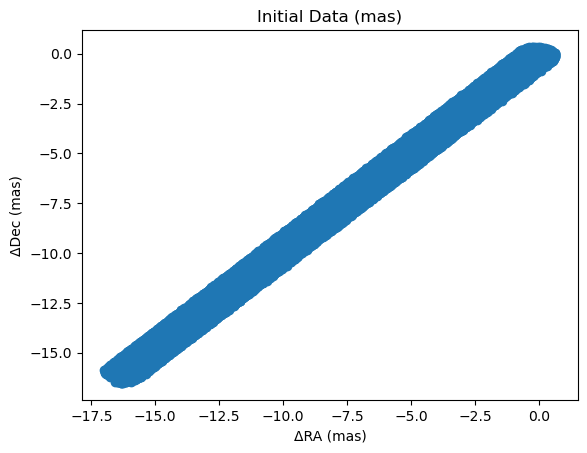

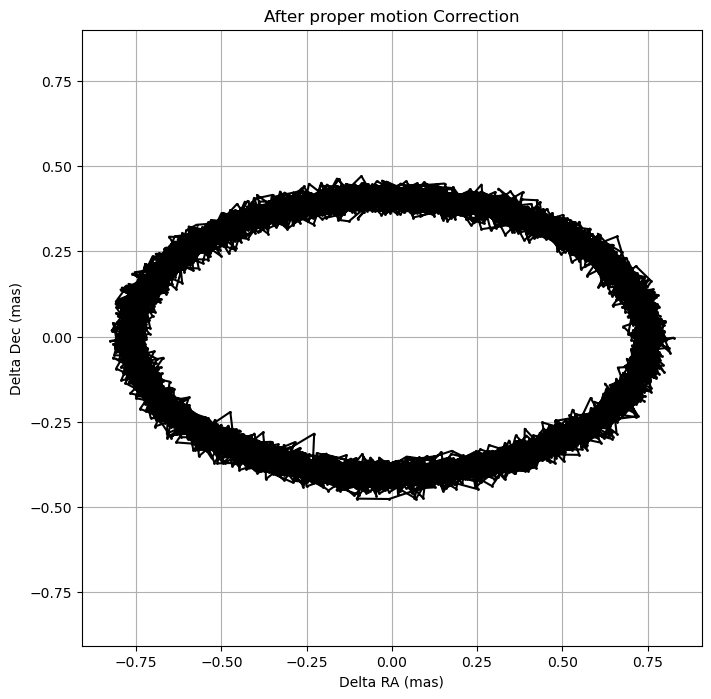

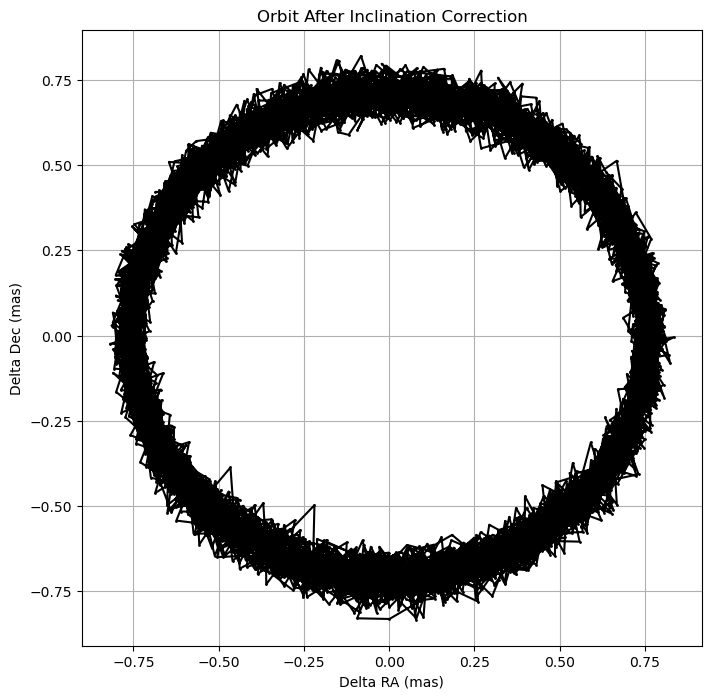

Radius is 1.6432797784934545 in AU
Calculated mass of parent object: 5912.09 solar masses


In [42]:
def analyze_orbit(filename, distance_pc):
    raw_data = load_data(filename)
    mas_data = convert_to_mas(raw_data)

    plot_full_data(mas_data)

    mu_ra, mu_dec = proper_motion(mas_data)
    corrected_data = remove_proper_motion(mas_data, mu_ra, mu_dec)

    plot_corrected_orbit(corrected_data)
    
    incl = inclination(corrected_data)
    rotated_orbit = rotate_orbit(corrected_data, incl)
    times = corrected_data[:, 2]

    x_centered = rotated_orbit[:, 0] 
    y_centered = rotated_orbit[:, 1] 
    centered_orbit = np.column_stack((x_centered, y_centered, times))

    plot_rotated_orbit(centered_orbit)

    r = np.mean(np.sqrt(x_centered**2 + y_centered**2))
    P = time_period(mas_data)/31536000
    mass = M(r, P, distance_pc)
    
    return mass



if __name__ == "__main__":
    filename = "body_data.csv"
    distance_pc = 2235.7
    mass = analyze_orbit(filename, distance_pc)
    print(f"Calculated mass of parent object: {mass:.2f} solar masses")

## Section 2: Theoretical Astronomy

Find the problems in the following PDF in the repo and add markdown and answer the questions:

In [43]:
# Q1
#a. radiation flux is equal to L/(4*pi*d*d)
#b. L*R^2*(1-alpha)/(4*d^2)
#c. L*R^2*alpha/(4*d^2)
#d. (L*(1-alpha)/16*pi*sigma*d^2)^(1/4)
#e. (L*(1-alpha)/8*pi*sigma*d^2)^(1/4)
#f. 209.9K

In [44]:
# Q2
# a. impact parameter e = Dl into Theta e, if we make the diagram for the beta equals 0 case, due to the fact that the angles are very small, phi * (Ds-Dl) = theta into Ds (using the distance S1 to S, and finding it using the formula angle into radius for an arc, (as angle is small arc's length will be similar to the straight line)x), after we input these 2 values of phi and e in the orignal equation given in the question, we will the formula for einstein radius Theta e
# b. 5.5 * 10^-9 radians or 1.14 mas
# c. assuming 300nm-700nm visible light, the resolution of the hubble telescope which is given by 1.22 into lambda / (diameter of aperture), the resolution angle is 42 mas -78 mas for that, and the angular radius is less than that so it will not be able to resolve this
# d. Theta 1 equals (Beta + sqrt(beta^2 + Theta e^2))/2 , Theta 2 = (Beta - sqrt(beta^2 + Theta e^2))/2
# e. Theta1/beta = 1/2n(n + root of (n^2 + 4)), Theta2/beta = 1/2n(n - root of (n^2 + 4)) (u might have to multiply a -1 for this to get ur desired result if u want to find magnitude)
# f. magnification 1 = m1^3/(n(m^2 + 1)), where m1 equals theta1/b into n annnnnnnnd magnifcation 2 equals m2^3/(n(m2^2 + 1)), where m2 equals theta2/b into n